# Model 2 Version 1 - Clustering Using Average Song and Playlist Features Values.
Our first attempt at model 2 uses the assumption that the data is Gaussian and perform KNN with the feature values of each song.

This code block imports all necessary libraries and fetches the average feature values given a title for the playlist.

In [6]:
import sys
sys.path.insert(0, '../../')

from common.utils import id_from_uri
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import json


FEATURE_NAMES = [
    "acousticness",
    "danceability",
    "duration_ms",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "time_signature",
    "valence"
]


def process_playlist(playlist: dict, song_conn: sqlite3.Connection):
    """
    Get information on a playlist given a playlist
    JSON dictionary and a connection to the song database.

    Params:
    - playlist: Dictionary of the JSON of a playlist from a slice.
    - song_conn: sqlite3.Connection to the song database.

    Returns:
    - (ids, playlist_df, title) where
        - ids: A list of song IDs in that playlist.
        - playlist_df: A dataframe of the mean and standard deviation 
                       features in the playlist.
        - title: The title of the playlist.
    """
    ids = [id_from_uri(track['track_uri']) for track in playlist['tracks']]

    # Queries for all the given songs. 
    # The interpolated bit expands to (?,?,?,?,...,?) for as many ids as we have,
    # so this is still a prepared statement and there is no SQL injection vulnerability.
    songs = pd.read_sql(
        "SELECT * FROM songs WHERE id IN ({0})".format(','.join('?' for _ in ids)),
        song_conn,
        params=ids,
    )

    means = songs[FEATURE_NAMES].mean(axis=0).add_suffix("_mean")
    # means = songs[FEATURE_NAMES].iloc[2].add_suffix("_mean")
    sds = songs[FEATURE_NAMES].std(axis=0).add_suffix("_sd")

    playlist_df = pd.concat((means, sds), axis=0)
    return ids, playlist_df, playlist['name']


def get_playlist_data_from_slice(slice_json, index, song_conn):
    """Get playlist data given the slice JSON its from and the playlist's index.

    Params:
    - slice_json: JSON dictionary of a slice file from the playlist database.
    - index: Index of the playlist desired within the slice.
    - song_conn: Connection to the sqlite3 song database.

    Returns:
    - (ids, playlist_df, title) where
        - ids: A list of song IDs in that playlist.
        - playlist_df: A dataframe of the mean and standard deviation 
                       features in the playlist.
        - title: The title of the playlist.
    """
    playlist_json = slice_json['playlists'][index]
    return process_playlist(playlist_json, song_conn)


with open('../../data/playlist/data/mpd.slice.0-999.json') as testSlice:
    slice_json = json.load(testSlice)

song_conn = sqlite3.Connection("../../data/song/song_dataset.db")
real_song_ids, playlist_row, playlist_title = get_playlist_data_from_slice(slice_json, 0, song_conn)

The following block of code retrieves the songs in the song dataset that are within the average and standard deviation values for each feature determined in the previous coding block. In other words it is determining the cluster of songs that are relevant to our given playlist.

In [7]:
import itertools

#Connects to the Song dataset
song_conn = sqlite3.Connection("../../data/song/song_dataset.db")

# SELECT * FROM songs WHERE (acousticness between ? AND ?) AND (...) AND ...
query = "SELECT * FROM songs WHERE {0}".format(
    ' AND '.join([
        f"({feature} BETWEEN ? AND ?)" for feature in FEATURE_NAMES
    ])
)

# [(min, max), (min, max), ...]
params_nested = [(
    playlist_row[f"{feature}_mean"]-3*playlist_row[f"{feature}_sd"],
    playlist_row[f"{feature}_mean"]+3*playlist_row[f"{feature}_sd"],
) for feature in FEATURE_NAMES]

# Flatten to [min, max, min, max, ...]
params = itertools.chain(*params_nested)


data = pd.read_sql(query, song_conn, params=params)
data.head()

,id,name,album,album_id,artists,artist_ids,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],0.026100,0.470,210133,0.978,0.000011,7,0.356,-5.399,1,0.0727,117.906,4.0,0.503
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],0.012900,0.599,206200,0.957,0.000071,11,0.155,-5.764,1,0.1880,103.680,4.0,0.489
2,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],0.163000,0.440,213640,0.967,0.000004,11,0.121,-5.830,0,0.2370,96.752,4.0,0.574
3,2LXPNLSMAauNJfnC58lSqY,Born of a Broken Man,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],0.053800,0.298,280960,0.848,0.001520,2,0.201,-5.947,1,0.0727,148.282,4.0,0.194
4,3moeHk8eIajvUEzVocXukf,Born As Ghosts,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],0.000427,0.417,202040,0.976,0.000134,9,0.107,-6.032,1,0.1750,90.395,4.0,0.483


In [8]:


#Extracts only the columns that contain the feature values of interest
relevant_columns = ['acousticness','danceability','energy', 'instrumentalness', 'liveness', 'loudness', 'mode','speechiness', 'tempo', 'time_signature', 'valence']
feature_matrix = data.loc[:, relevant_columns]

#Converts the pandas datafram into a numpy array.
feature_matrix = feature_matrix.to_numpy() 

#Contains the mean values for all features
means = np.array([
    playlist_row[f"{feature}_mean"]
    for feature in relevant_columns
])

#Contains the std deviation values for all features.
stds = np.array([
    playlist_row[f"{feature}_sd"]
    for feature in relevant_columns
])

# Set standard deviations of 0 to a very small number to avoid 
# division by 0 errors.
stds[stds == 0] = 1e-10

#Calculated distances from each song to center
distances = np.sqrt(
    np.sum(
        ((feature_matrix - means) / stds)**2, 
    axis=1)
)

data['distances'] = distances
ranked_id_list = data[['id', 'distances']].sort_values(by="distances")
ranked_id_list = ranked_id_list['id'].tolist()
ranked_id_list

['7f5XDgmeSqCNgpTAOSVRUh',
 '3nPIWr2WnEdbc9P8hrkLbj',
 '3tMyxF6Erg2AQPLTY9pMxx',
 '6eolFkFTZmdai6b47dxKtJ',
 '35BXOeMdVF2TnuEnfnJecW',
 '4YMJTBzfR8dhdPE3wrguw6',
 '40bxDmUIpgXDff9g1lPn2T',
 '0KJmsQNMPf2rG5E1UbroBs',
 '2KPL20JCgAADW3VTGlfmJQ',
 '6lVYPZ82OcB3Y7jUmYfvhw',
 '1yKwm3bqrKknMkzSQgZq7g',
 '7iTehkjQ2kYM0kLMOwspKy',
 '6jOKCCItTmgS1ciHb3v5nt',
 '228Jrhmd6K7K4yMetUuQpj',
 '1bN8bV3wQDORnIBagHT5tu',
 '43WhZVAwlgiczgHayaT8ae',
 '3fRrqxUYkIQw1vzCl73CYZ',
 '6ucMqrnJH1G49bWX3552H9',
 '3f0KBacw4EQjSlQItvDwvk',
 '2dcNtdDp0zbmvMJsVICIfe',
 '4DRHveoymfK4aIlW3JjTYM',
 '7v2PNdKG7q3WswT6JIQlcZ',
 '2imnZynbNLGw3Bg2Kd6bgf',
 '2758wUNcjAKwVN6vcKFOIm',
 '5YJ0skrgTGlgsvSm4vMEk3',
 '0u7MztV2VOlvZhYdfSLILu',
 '3GxIkn14V7aibrIZv7jZsM',
 '6uNOASU0rKkjdc9Rk8wPan',
 '3TANeVSw5As1tqksqIWoDo',
 '42yndiNCCTbXViWovB3iBK',
 '2cls4groLeYT1zmlXN1pO2',
 '1fXsYDOzlEA675Ohfhw3ld',
 '6LnlV06TGIKxJRW8ZnTCQf',
 '5j4mKTvOu0cr4cooq57sm3',
 '7bjK9UIadpjfbBxt1Tw5Jg',
 '7Ih5e78qM4NduRZ6gtBD1M',
 '1P1D5KqiWmeYk0d1ze8abX',
 

NDCG:           0.21665388484376463
First index:    379 (out of 688836 predictions)
Songs found:    48 (out of 52 in actual)
Recall@1000:    0.019230769230769232
Recall@5000:    0.057692307692307696
Recall@10000:   0.057692307692307696


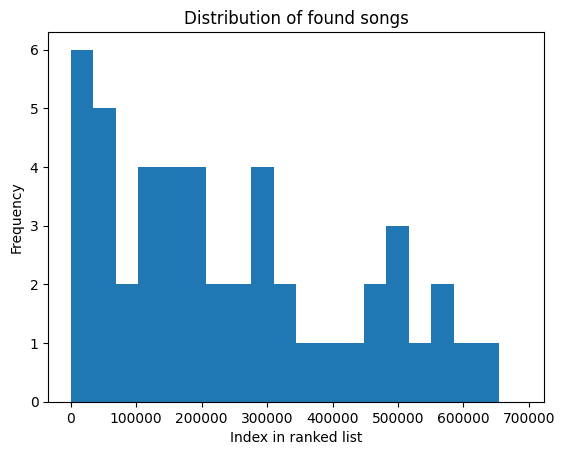

In [9]:
from common.metrics import ndcg, first_index, recall_k, num_found, indexes

# Metrics
print(f"NDCG:           {ndcg(real_song_ids, ranked_id_list)}")
print(f"First index:    {first_index(real_song_ids, ranked_id_list)} (out of {len(ranked_id_list)} predictions)")
print(f"Songs found:    {num_found(real_song_ids, ranked_id_list)} (out of {len(real_song_ids)} in actual)")
print(f"Recall@1000:    {recall_k(real_song_ids, ranked_id_list, 1000)}")
print(f"Recall@5000:    {recall_k(real_song_ids, ranked_id_list, 5000)}")
print(f"Recall@10000:   {recall_k(real_song_ids, ranked_id_list, 10000)}")

plt.figure()
plt.hist(indexes(real_song_ids, ranked_id_list), bins=20, range=(0, len(ranked_id_list)))
plt.title("Distribution of found songs")
plt.xlabel("Index in ranked list")
plt.ylabel("Frequency")
plt.show()